In [1]:
import math
import pprint
import datetime
import numpy as np
import pandas as pd
from dateutil import parser
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pandas.tseries.offsets import BDay

In [2]:
%matplotlib inline

## Global variables

In [3]:
DATA_DIR = '../data'
IS_BUSINESS_DAY = BDay().is_on_offset

STARTING_VAULT_AMOUNT = 2000
PP = pprint.PrettyPrinter(depth=6)

### Reading and basic preprocessing of data

In [4]:
raw_xau_cny = pd.read_csv(f'{DATA_DIR}/XAU_CNY_5Y.csv')
raw_xau_cny = raw_xau_cny.iloc[:, [0, 1]]

# The prices/numbers are in ',' seperated values.
raw_xau_cny['Price'] = raw_xau_cny['Price'].str.replace(',', '').astype(float)

raw_xau_cny['Date'] = pd.to_datetime(raw_xau_cny['Date'])
raw_xau_cny = raw_xau_cny.sort_values(by=['Date']).reset_index(drop=True)

print(f'There are {raw_xau_cny.shape[0]} values for XAU/CNY')

There are 1341 values for XAU/CNY


In [5]:
raw_usd_cny = pd.read_csv(f'{DATA_DIR}/USD_CNY_5Y.csv')
raw_usd_cny = raw_usd_cny.iloc[:, [0, 1]]

raw_usd_cny['Date'] = pd.to_datetime(raw_usd_cny['Date'])
raw_usd_cny = raw_usd_cny.sort_values(by=['Date']).reset_index(drop=True)

print(f'There are {raw_usd_cny.shape[0]} values for USD/CNY')

There are 1301 values for USD/CNY


In [6]:
# Remove non-business days.
xau_cny_valid_dates = raw_xau_cny['Date'].map(IS_BUSINESS_DAY)
usd_cny_valid_dates = raw_usd_cny['Date'].map(IS_BUSINESS_DAY)

# Select business dates data.
xau_cny = raw_xau_cny[xau_cny_valid_dates].reset_index(drop=True)
usd_cny = raw_usd_cny[usd_cny_valid_dates].reset_index(drop=True)

print('Shape after preprocessing is :')
print('For XAU/CNY', xau_cny.shape)
print('For USD/CNY', usd_cny.shape)

Shape after preprocessing is :
For XAU/CNY (1305, 2)
For USD/CNY (1301, 2)


In [7]:
start_date = pd.Timestamp('today').floor('D') + pd.Timedelta(-3* 365, unit='D')
end_date = pd.Timestamp('today').floor('D') + pd.Timedelta(-0 * 365, unit='D')

xau_cny = raw_xau_cny[(raw_xau_cny['Date']>=start_date) & (raw_xau_cny['Date']<=end_date)].reset_index(drop=True)
usd_cny = raw_usd_cny[(raw_usd_cny['Date']>=start_date) & (raw_usd_cny['Date']<=end_date)].reset_index(drop=True)

# xau_cny = xau_cny[(xau_cny['Date']>=start_date)].reset_index(drop=True)
# usd_cny = usd_cny[(usd_cny['Date']>=start_date)].reset_index(drop=True)

print('Shape after sub setting is :')
print('For XAU/CNY', xau_cny.shape)
print('For USD/CNY', usd_cny.shape)

appreciating_asset = xau_cny[:]
appreciating_asset.Price = range(1000, 1000 + len(appreciating_asset.Price), 1)

depreciating_asset = xau_cny[:]
depreciating_asset.Price = range(1000, 1000 + len(depreciating_asset.Price), 1)[::-1]

Shape after sub setting is :
For XAU/CNY (811, 2)
For USD/CNY (776, 2)


In [8]:
def plot_results (plot_data):
    gs = gridspec.GridSpec(5, 2)

    pl.figure(figsize=(8, 8))
    pl.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=1)

    ax = pl.subplot(gs[0,:]) # row 0, col 0
    plt.title('A Price')
    plt.plot(plot_data['dates'], plot_data['a_price'], color='blue')

    ax = pl.subplot(gs[1, 0]) # row 0, col 1
    plt.title('A buying power')
    plt.plot(plot_data['dates'], plot_data['a_buying_power'], color='blue')

    ax = pl.subplot(gs[1, 1]) # row 0, col 1
    plt.title('A held quantity')
    plt.plot(plot_data['dates'], plot_data['a'], color='blue')

    ax = pl.subplot(gs[2,:]) # row 0, col 0
    plt.title('B Price')
    plt.plot(plot_data['dates'], plot_data['b_price'], color='blue')

    ax = pl.subplot(gs[3, 0]) # row 0, col 1
    plt.title('B buying power')
    plt.plot(plot_data['dates'], plot_data['b_buying_power'], color='blue')

    ax = pl.subplot(gs[3, 1]) # row 0, col 1
    plt.title('B held quantity')
    plt.plot(plot_data['dates'], plot_data['b'], color='blue')

    ax = pl.subplot(gs[4, :]) # row 1, span all columns
    plt.title('Valut Buying Power')
    plt.plot(plot_data['dates'], plot_data['vault'], color='blue')

In [11]:
def simulate_model_with_same_bp(A, B, 
                                ratio_a=0.5, ratio_b=0.5, 
                                starting_amount=2000, 
                                slippage=0.05, # 5% slippage
                                sell_apr_percentage = 0.01, # sell off at most 1% of the appreciation over time
                                rebalance_interval_days=7 # recalcualte the buying power every X days
                               ):
    if A.shape[0] < B.shape[0]: A, B = B, A
    
    a_prev = A.iloc[0, :]
    b_prev = B.iloc[0, :]
    
    slippage_multiplier = (1 - slippage)
    counter = 0
    
    plot_data = {
        'dates': [],
        'vault': [],
        'a': [],
        'b': [],
        'a_price': [],
        'b_price': [],
        'a_buying_power': [],
        'b_buying_power': []
    }
    
    START_CONFIG = {
        'vault': starting_amount,
        'a': 0,
        'b': 0,
        'a_buying_power': ratio_a * starting_amount,
        'b_buying_power': ratio_b * starting_amount
    }
        
    # a * a_price = a_buying_power

    START_CONFIG['a'] = START_CONFIG.get('a_buying_power', 1000) / a_prev.Price
    START_CONFIG['b'] = START_CONFIG.get('b_buying_power', 1000) / b_prev.Price

    print('Start with values')
    PP.pprint(START_CONFIG)
    print()
    
    for i in A.index.to_list():
        # Take the latest value or the last value.
        if i < A.shape[0]: a = A.loc[i, :]
        else: a = A.loc[A.index.to_list()[-1], :]

        if i < B.shape[0]: b = B.loc[i, :]
        else: b = B.loc[B.index.to_list()[-1], :]

        # calculate old buying power
        old_a_buying_power = START_CONFIG['a_buying_power']
        old_b_buying_power = START_CONFIG['b_buying_power']
        old_buying_power = old_a_buying_power + old_b_buying_power
        
        # calculate new buying power
        new_a_balance = START_CONFIG['a']
        new_b_balance = START_CONFIG['b']
        new_a_buying_power = new_a_balance * a.Price
        new_b_buying_power = new_b_balance * b.Price
        
        # check if the new buygin power has increased; only in which case do we rebalance
        new_buying_power = (new_a_buying_power + new_b_buying_power) 
        
        # now the target buying power should be something that maintains the ratio we 
        # have above.
        target_buying_power = new_a_buying_power * ratio_a + new_b_buying_power * ratio_b
        
        START_CONFIG['a_buying_power'] = new_a_buying_power
        START_CONFIG['b_buying_power'] = new_b_buying_power

        # caclulate the change in buying powr
        diff_a_b_buying_power = abs(new_a_buying_power - new_b_buying_power)
        
        # Rebalance the assets.        
        if (new_a_buying_power < new_b_buying_power):
            # if A has more buying power then we sell `sell_apr_percentage`% of the profits in A and buy B
            new_a_balance -= diff_a_b_buying_power / a.Price * slippage_multiplier * sell_apr_percentage
            new_b_balance += diff_a_b_buying_power / b.Price * slippage_multiplier * sell_apr_percentage
        else:
            # and vice versa
            new_a_balance -= diff_a_b_buying_power / a.Price * slippage_multiplier * sell_apr_percentage
            new_b_balance += diff_a_b_buying_power / b.Price * slippage_multiplier * sell_apr_percentage

        # don't do anything if there is no change in the buying power or if we sell assets or if the quantity 
        # one of the underlying goes to 0. Ideally we should make sure that we buy/sell as much so that the
        # underlying does not get fully sold off.
        if i % rebalance_interval_days != 0 or (new_buying_power < old_buying_power) or new_a_balance <= 0 or new_b_balance <= 0:
            plot_data['dates'].append(a.Date)
            plot_data['vault'].append(new_buying_power)
            plot_data['a'].append(START_CONFIG['a'])
            plot_data['b'].append(START_CONFIG['b'])
            plot_data['a_price'].append(a.Price)
            plot_data['b_price'].append(b.Price)
            plot_data['a_buying_power'].append(new_a_buying_power)
            plot_data['b_buying_power'].append(new_b_buying_power)
            continue

        counter += 1
            
        # Recalculate the vault balance.
        START_CONFIG['a'] = new_a_balance
        START_CONFIG['b'] = new_b_balance
        START_CONFIG['vault'] = START_CONFIG.get('a_buying_power') + START_CONFIG.get('b_buying_power')
        
        plot_data['dates'].append(a.Date)
        plot_data['vault'].append(START_CONFIG['vault'])
        plot_data['a'].append(START_CONFIG['a'])
        plot_data['b'].append(START_CONFIG['b'])
        plot_data['a_price'].append(a.Price)
        plot_data['b_price'].append(b.Price)
        plot_data['a_buying_power'].append(new_a_buying_power)
        plot_data['b_buying_power'].append(new_b_buying_power)
#         print()
#         PP.pprint(START_CONFIG)
        
        if (START_CONFIG['vault'] - starting_amount) / starting_amount <= -0.3: 
            print('Breaking')
            break

        a_prev, b_prev = a, b
        
    print("finished with %d rebalances" % counter)
    print("final buying power of the vault is %d" % (new_a_buying_power + new_b_buying_power))
        
    return plot_data, START_CONFIG

Start with values
{'a': 0.11605815442001677,
 'a_buying_power': 1000.0,
 'b': 152.1097624045511,
 'b_buying_power': 1000.0,
 'vault': 2000}

finished with 59 rebalances
final buying power of the vault is 2565


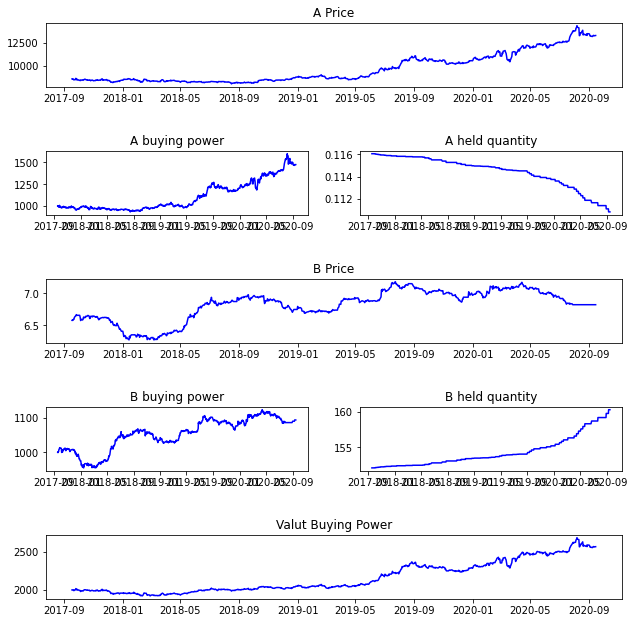

In [12]:
# USD and GOLD with a 50-50 ratio and slippage of 5% and 7 day rebalance interval
results, config = simulate_model_with_same_bp(
    usd_cny, xau_cny, 0.5, 0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    rebalance_interval_days=7
    
)
plot_results(results)

Start with values
{'a': 0.11605815442001677,
 'a_buying_power': 1000.0,
 'b': 152.1097624045511,
 'b_buying_power': 1000.0,
 'vault': 2000}

finished with 256 rebalances
final buying power of the vault is 2053


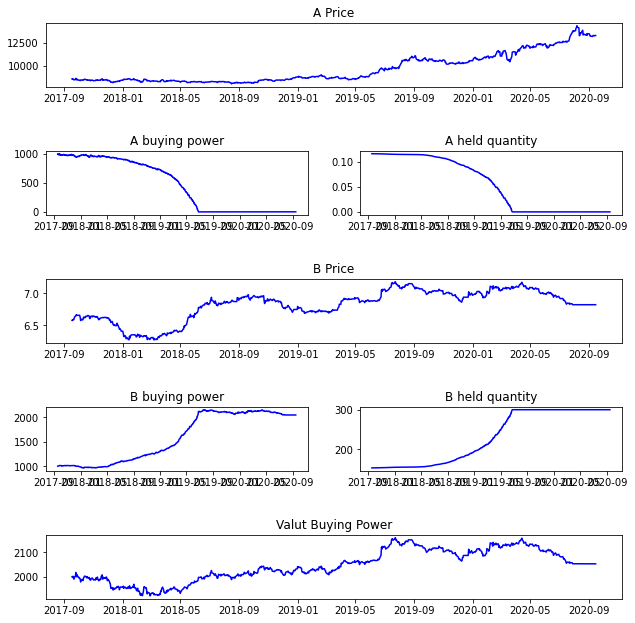

In [13]:
# USD and GOLD with a 50-50 ratio and slippage of 5% and 1 day rebalance interval
results, config = simulate_model_with_same_bp(
    usd_cny, xau_cny, 0.5, 0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    rebalance_interval_days=1
)

plot_results(results)

# eventually we run out of one side of asset because we rebalance too much; 
# so we should ideally avoid this scenario..

Start with values
{'a': 0.11605815442001677,
 'a_buying_power': 1000.0,
 'b': 152.1097624045511,
 'b_buying_power': 1000.0,
 'vault': 2000}

finished with 8 rebalances
final buying power of the vault is 2167


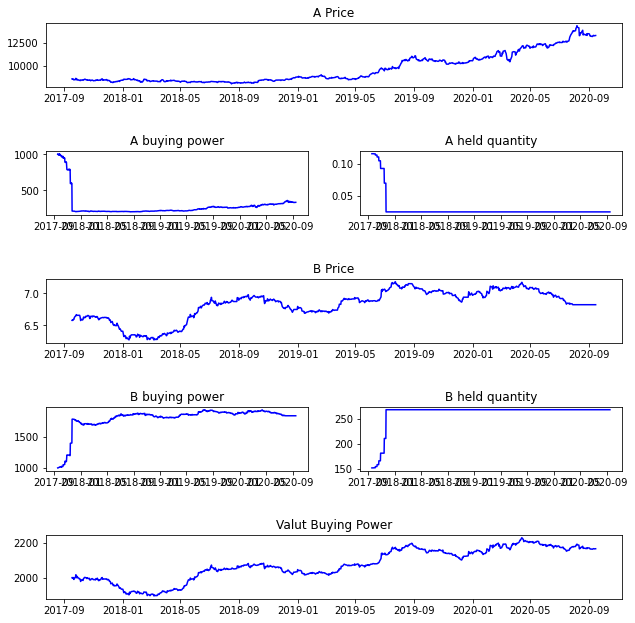

In [14]:
# USD and GOLD with a 50-50 ratio and slippage of 5% and 1 day rebalance interval; but selling 50% of 
# the appreciated side instead of 1%
results, config = simulate_model_with_same_bp(
    usd_cny, xau_cny, 0.5, 0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    rebalance_interval_days=7,
    sell_apr_percentage=0.5
)

plot_results(results)

# eventually we run out of one side of asset because we sell too much; 
# so we should ideally avoid this scenario..

Start with values
{'a': 0.11605815442001677,
 'a_buying_power': 1000.0,
 'b': 152.1097624045511,
 'b_buying_power': 1000.0,
 'vault': 2000}

finished with 59 rebalances
final buying power of the vault is 2579


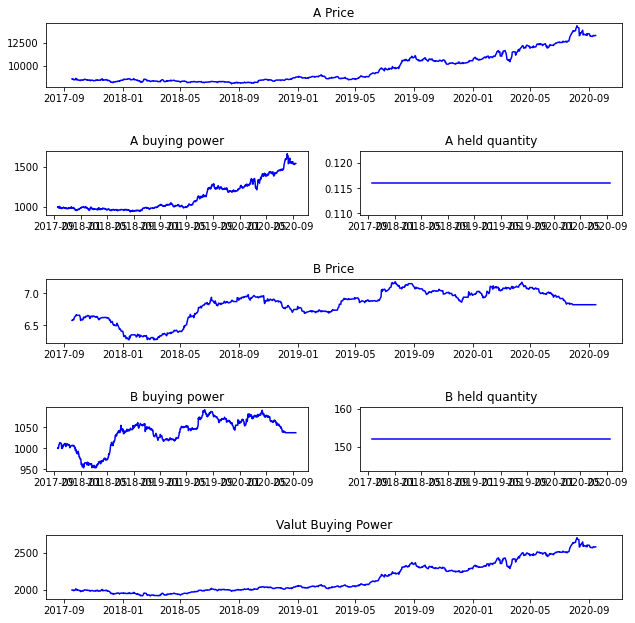

In [13]:
# USD and GOLD with a 50-50 ratio with no rebalancing
results, config = simulate_model_with_same_bp(
    usd_cny, xau_cny, 0.5, 0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    sell_apr_percentage=0
)

plot_results(results)

Start with values
{'a': 1.0,
 'a_buying_power': 1000.0,
 'b': 0.5524861878453039,
 'b_buying_power': 1000.0,
 'vault': 2000}

finished with 103 rebalances
final buying power of the vault is 2197


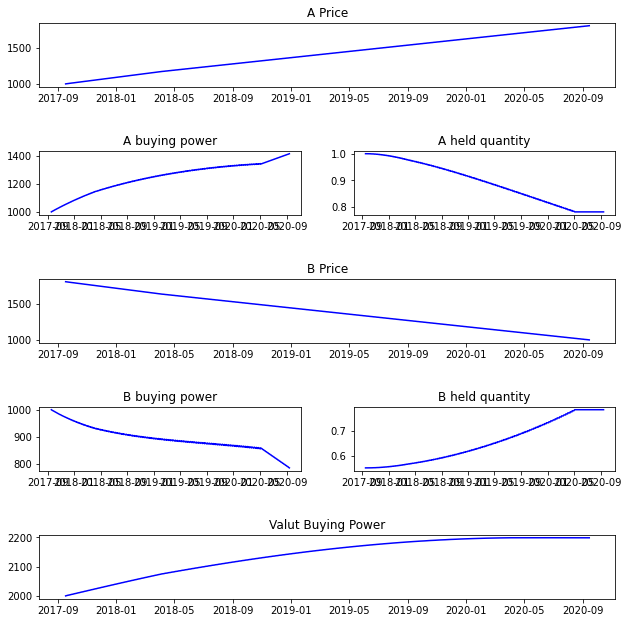

In [14]:
# With one appreciating asset and one depreciating asset. The net result is on the positive.
results, config = simulate_model_with_same_bp(
    appreciating_asset, depreciating_asset, 0.5, 0.5, 
    STARTING_VAULT_AMOUNT
)

plot_results(results)

Start with values
{'a': 0.5524861878453039,
 'a_buying_power': 1000.0,
 'b': 0.5524861878453039,
 'b_buying_power': 1000.0,
 'vault': 2000}

finished with 1 rebalances
final buying power of the vault is 1104


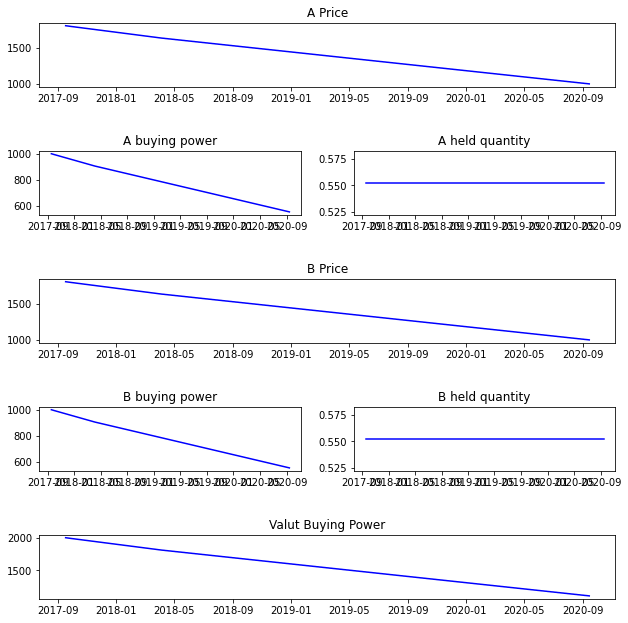

In [15]:
# With two depreciating assets. Really nothing we can do here. the
# net loss in the vault is the averaged loss; Which shows the importance of
# choosing two assets that are hedges of each other...

results, config = simulate_model_with_same_bp(
    depreciating_asset, depreciating_asset, 0.5, 0.5, 
    STARTING_VAULT_AMOUNT
)

plot_results(results)